# Highest score in Tiny ImageNet validation dataset

The goal was to achieve the highest possible (at least 55%) accuracy in the Tiny ImageNet validation dataset.
The sample code provided, which utilizes ResNet18 (not pre-trained?) model achieved 50% accuracy after 30 epochs.

First I tried training with sample code and different combinations of augmentations. Not all of the tries successfully trained for 30 epochs, but those that did (original default.yaml for example) had a worse or negligible difference in performance. 

Then I tried modifying the number of epochs.
The example code achieved an accuracy of about 55% at aroud 50 epochs, at which point the accuracy plateaued.

I tried to use a different network with the sample code provided but the files I needed to change were all over the place. So I decided to follow a tutorial in [TDS article](https://towardsdatascience.com/pytorch-ignite-classifying-tiny-imagenet-with-efficientnet-e5b1768e5e8f). This example used EfficientNet-B3 pretrained network.


In [30]:
import os
import sys

os.chdir('..')
os.getcwd()

import torch
import pandas as pd

import seaborn as sns

from pathlib import Path

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from functools import reduce

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Use {device}')

from importlib import reload 


Use cpu


### Visualizing tensorboard stats

In [31]:
def read_tensorboard(path, tags=['training/accuracy', 'validation/accuracy']):
    ea =  EventAccumulator(path)
    ea.Reload()
    dfs = []
    for tag in tags:
        df = pd.DataFrame(ea.Scalars(tag)).drop('wall_time', 1)
        df.columns = ['step', tag]
        dfs.append(df)
    dfs = reduce(lambda left, right: pd.merge(left, right, on='step'), dfs)
    return dfs

In [34]:
training_v1 = read_tensorboard('content/events.out.tfevents.1638201141.cbdab2f461ad')

training = pd.concat([
    training_v1.assign(model='efficientnet_test0'),
])
training = training.melt(id_vars=['step', 'model'], value_name='accuracy', var_name='split')

training.split = training.split.str.replace('_acc', '')

training.head(10)

,step,model,split,accuracy
0,1,efficientnet_test0,training/accuracy,0.52830
1,2,efficientnet_test0,training/accuracy,0.62055
2,3,efficientnet_test0,training/accuracy,0.66301
3,1,efficientnet_test0,validation/accuracy,0.48870
4,2,efficientnet_test0,validation/accuracy,0.55140
5,3,efficientnet_test0,validation/accuracy,0.56940


Plot training curves

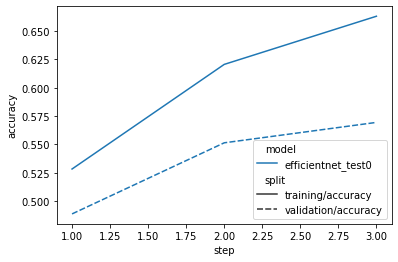

In [35]:
sns.lineplot(x='step', y='accuracy', hue='model', style='split', data=training)
plt.show()

After training for 3 epochs the model achieved a validation accuracy of 57%.
Since the training ran for 3 epochs only (1h in Kaggle/2h in Colab), it is hard to say what is the limit of this model if given more computation time. Probaby could reach 60% by 10 epochs?

## Evaluate trained weights
Upload weights file "default_efficientnet_accyracy_0.5694.pt" to colab directory 'content/'.\
Run code blocks below to evaluate trained model.

##### Use our trained weights

In [81]:
!pip install efficientnet-pytorch

# Define model architecture (using efficientnet-b3 version)
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=200)

state_dict = torch.load('content/default_efficientnet_accuracy_0.5694.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

Loaded pretrained weights for efficientnet-b3


<All keys matched successfully>

#### Create validation dataloader

In [91]:
from torchvision import transforms as T
from torch.utils.data import DataLoader, TensorDataset, Dataset


# Define device to use (CPU or GPU). CUDA = GPU support for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Setup function to create dataloaders for image datasets
def generate_dataloader(data, name, transform):
    if data is None: 
        return None
    
    # Read image files to pytorch dataset using ImageFolder, a generic data 
    # loader where images are in format root/label/filename
    # See https://pytorch.org/vision/stable/datasets.html
    if transform is None:
        dataset = datasets.ImageFolder(data, transform=T.ToTensor())
    else:
        dataset = datasets.ImageFolder(data, transform=transform)

    # Set options for device
    if use_cuda:
        kwargs = {"pin_memory": True, "num_workers": 1}
    else:
        kwargs = {}
    
    # Wrap image dataset (defined above) in dataloader 
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                        shuffle=(name=="train"), 
                        **kwargs)
    
    return dataloader

# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')

# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Display first 10 entries of resulting val_img_dict dictionary
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}


# Create subfolders (if not present) for validation images based on label,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

# Create DataLoader
val_loader_pretrain = generate_dataloader(val_img_dir, "val",
                                 transform=None)

#### Measure model accuracy

In [93]:
from torch.autograd import Variable


correct = 0
total = 0
for data in val_loader_pretrain:
    images, labels = data
    outputs = model(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    print("pred: ", predicted)
    print("Act: ", labels)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    #print(f'Progress --- total: {total}, correct: {correct}')
print('Accuracy of the network on the 10000 test images: ', (100 * correct / total))

pred:  tensor([ 55,  69, 144,   0,  85, 137, 152, 119,  44,  67, 196,   5, 146,  67,
         55])
Act:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
pred:  tensor([152,  62, 164, 174, 118,   4,  69, 147,  83,  88, 192,  37,  80, 167,
         69])
Act:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
pred:  tensor([171, 140, 189,  96,  44,  85,  69,  40,  88,  71, 142, 182,  53, 135,
        188])
Act:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
pred:  tensor([ 88,  36, 175, 148,   0,  48,  40, 146,  61,  39,  67, 127, 196,  85,
         75])
Act:  tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
pred:  tensor([125,  73, 154,  82, 146, 178,  91,  75, 137,   9, 182,  96,  23,  40,
        114])
Act:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
pred:  tensor([154, 147, 189, 144, 145, 146,  82, 151,  85, 171,  60, 145, 186,  72,
         40])
Act:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
pred:  tensor([162, 196, 142,  40, 174,  36,  

KeyboardInterrupt: ignored

Can't get validation dataloader set up correctly, labels are not correct. The trained weights should still be 57% accurate.

Other notes:\
90% of trainings crashed when using provided sample code which heavily limited number of tests with different parameters.

After using TowardsDataScience example no major problems occured. Sometimes only GPU out of memory error.


